# Get dataset with fingerprints

# Get ECFP4 fingerprints using RDKit module (skip if reloading)

In [1]:
import os, sys
import pandas as pd
df = pd.read_csv("XY_AOT_CDKPaDEL_processed.csv")

C:\Users\cavio\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
smi = df['Canonical_QSARr'].values

In [3]:
import numpy as np
def fp_to_int(fp_string):
    return np.array([int(i) for i in fp_string])

In [65]:
from rdkit import Chem
from rdkit.Chem import AllChem
#There are two chemical structures with Boron that had an issue with conversion. By including a negative sign on the Boron atom, we can convert the molecule to rdkit.Chem.Mol
smi[3646]= "C1=CC=CC=C1[B-](C1C=CC=CC=1)(C1C=CC=CC=1)C1C=CC=CC=1"
smi[8536]= "O=C1O[B-]2(OC1=O)OC(=O)C(=O)O2"
mol = [Chem.MolFromSmiles(s) for s in smi]
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol]
fp = np.array([fp_to_int(f.ToBitString()) for f in fp])

In [66]:
pd.DataFrame(fp).to_csv("XY_AOT_Morgan2.csv")

# Feature selection (skip if reloading)

In [76]:
import os, sys
import pandas as pd
import numpy as np
df = pd.read_csv("XY_AOT_CDKPaDEL_processed.csv")
fp = pd.read_csv("XY_AOT_Morgan2.csv", index_col=0).values

label_start = 7
feat_start = 12
train_ind = np.where(df['Type']=='Training')[0]
test_ind = np.where(df['Type']=='Testing')[0]

train_labels = df.iloc[train_ind,label_start:feat_start]
train_features = df.iloc[train_ind, feat_start:].values
test_labels = df.iloc[test_ind, label_start:feat_start]
test_features = df.iloc[test_ind, feat_start:].values
labels = df.columns[label_start:feat_start]

C:\Users\cavio\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
def median_imputation(X_train, X_test):
    for col in range(len(X_train[0])):
        med=np.nanmedian(X_train[:,col])
        
        train_nanind=np.where(np.isnan(X_train[:,col]))[0]
        test_nanind=np.where(np.isnan(X_test[:,col]))[0]
        
        if len(train_nanind)>0:
            X_train[train_nanind,col]=med
        if len(test_nanind)>0:
            X_test[test_nanind,col]=med
    return X_train, X_test

def zero_imputation(y):
    for col in range(len(y[0])):
        nan_ind=np.where(np.isnan(y[:,col]))[0]
        if len(nan_ind)>0:
            y[nan_ind,col]=0
    return y

#Remove features with more than 1 missing values
retain_feat_ind=np.where(np.sum(np.isnan(train_features),
                                axis=0)<2)[0]
print(f"{len(retain_feat_ind)} out of {train_features.shape[1]} feature retained")
data_cols = df.columns[feat_start:][retain_feat_ind]
#Impute missing values
train_features, test_features = median_imputation(
    train_features[:, retain_feat_ind], 
    test_features[:, retain_feat_ind]
)


1032 out of 1326 feature retained


In [81]:
all_features = pd.DataFrame(np.vstack([train_features, test_features]), 
                            columns = data_cols
                           )
all_fp = pd.DataFrame(fp, 
                      columns = [f"ECFP{i:4d}" for i in range(fp.shape[1])])
all_features = pd.concat([all_features, all_fp], 
                        axis=1)


In [82]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

train_ind = np.where(df['Type']=='Training')[0]
train_features = all_features.iloc[train_ind,:]
train_targets = train_labels.iloc[train_ind, :]

supports=[]
for i in range(train_targets.shape[1]):
    valid_ind = ~np.isnan(train_targets.iloc[:,i].astype(np.float))
    train_target = train_targets[valid_ind].iloc[:,i].values.astype(
        float)
    if i!=2:
        clf=ExtraTreesClassifier(n_estimators=499, random_state=123)
    else:
        clf=ExtraTreesRegressor(n_estimators=499, random_state=123)
    clf.fit(train_features[valid_ind], train_target)
    model=SelectFromModel(clf, prefit=True)
    supports.append(model.get_support())


(array([1747.,  331.,   53.,   54.,  322.,  573.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

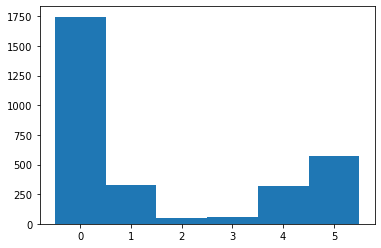

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
counts = np.sum(supports, axis=0)
plt.hist(counts, np.array(list(range(7)))-0.5, )

In [84]:
for i in range(5):
    print(f"Proportion of features that are important in at least {i+1} problem(s): {np.sum(counts>i)/len(counts):.3f}")

Proportion of features that are important in at least 1 problem(s): 0.433
Proportion of features that are important in at least 2 problem(s): 0.325
Proportion of features that are important in at least 3 problem(s): 0.308
Proportion of features that are important in at least 4 problem(s): 0.291
Proportion of features that are important in at least 5 problem(s): 0.186


In [85]:
thresh = 4
selected_feat_ind = np.where(counts>thresh-0.5)[0]

to_save = all_features.iloc[:, selected_feat_ind]
to_save = pd.concat([df.iloc[:, :feat_start], to_save], 
                    axis=1
                   )

to_save.to_csv("AOT_CDKPaDELMorgan2_filtered.csv")

In [86]:
thresh = 1
selected_feat_ind = np.where(counts>thresh-0.5)[0]

to_save = all_features.iloc[:, selected_feat_ind]
to_save = pd.concat([df.iloc[:, :feat_start], to_save], 
                    axis=1
                   )

to_save.to_csv("AOT_CDKPaDELMorgan2_filtered_morefeats.csv")

# Cosa model feature weights calculation

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("AOT_CDKPaDELMorgan2_filtered.csv",
                 index_col=0
                )
label_start = 7
feat_start = 12
train_ind = np.where(df['Type']=='Training')[0]
test_ind = np.where(df['Type']=='Testing')[0]

train_features = df.iloc[train_ind, feat_start:].values
test_features = df.iloc[test_ind, feat_start:].values
train_targets = df.iloc[train_ind, label_start:feat_start]
test_targets = df.iloc[test_ind, label_start:feat_start]

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
import os, sys
sys.path.append(os.path.join("..","..","..","0_code"))

from algorithms import COSA
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, n_iter=100,
                                distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=8
                    )
cosa_mdl.fit(train_features)
Fweights_train=cosa_mdl.output_Fweight()
cosa_dist_train=cosa_mdl.output_Dmat()

Starting on outer iteration 1; beta/eta:0.220
Wchange:0.669, Crit:Not calculated
Wchange:0.161, Crit:Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:0.072, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:0.039, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 4; beta/eta:0.280
Wchange:0.023, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 5; beta/eta:0.300
Wchange:0.015, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 6; beta/eta:0.320
Wchange:0.010, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 7; beta/eta:0.340
Wchange:0.008, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 8; beta/eta:0.360
Wc

Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 64; beta/eta:1.480
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 65; beta/eta:1.500
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 66; beta/eta:1.520
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 67; beta/eta:1.540
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 68; beta/eta:1.560
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 69; beta/eta:1.580
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 70; beta/eta:1.600
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at

In [5]:
cosa_mdl.fit_OOS(test_features)
Fweights_test = cosa_mdl.output_Fweight(OOS=True)
cosa_dist_test = cosa_mdl.output_Dmat(OOS=True)

Starting on outer iteration 1; beta/eta:0.220
Wchange:1734929.649, Crit: Not calculated
Wchange:424831.332, Crit: Not calculated
Wchange:177925.564, Crit: Not calculated
Wchange:85867.335, Crit: Not calculated
Wchange:50618.524, Crit: Not calculated
Wchange:33553.386, Crit: Not calculated
Wchange:24365.303, Crit: Not calculated
Wchange:13365.191, Crit: Not calculated
Wchange:7729.653, Crit: Not calculated
Wchange:5709.870, Crit: Not calculated
Inner loop converged in (or maxed out) at 10 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:18439.963, Crit: Not calculated
Wchange:4001.570, Crit: Not calculated
Wchange:1290.659, Crit: Not calculated
Wchange:392.056, Crit: Not calculated
Wchange:255.816, Crit: Not calculated
Wchange:65.863, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 7 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:15800.424, Crit: Not calculated
Wchange:2042.167, Crit: Not calculated
Wchange:511.9

Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 30; beta/eta:0.800
Wchange:5232.661, Crit: Not calculated
Wchange:463.049, Crit: Not calculated
Wchange:27.218, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 31; beta/eta:0.820
Wchange:4779.482, Crit: Not calculated
Wchange:560.703, Crit: Not calculated
Wchange:52.055, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 32; beta/eta:0.840
Wchange:5793.094, Crit: Not calculated
Wchange:694.288, Crit: Not calculated
Wchange:55.134, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 33; beta/eta:0.860
Wchange:4657.383, Crit: Not calculated
Wchange:1006.453, Crit: Not calculated
Wchange:392.977, Crit: Not calculated
Wchange:30

Wchange:2435.028, Crit: Not calculated
Wchange:297.212, Crit: Not calculated
Wchange:30.769, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 64; beta/eta:1.480
Wchange:2935.391, Crit: Not calculated
Wchange:717.792, Crit: Not calculated
Wchange:64.203, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 65; beta/eta:1.500
Wchange:2683.244, Crit: Not calculated
Wchange:312.843, Crit: Not calculated
Wchange:136.684, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 4 steps
Starting on outer iteration 66; beta/eta:1.520
Wchange:2019.883, Crit: Not calculated
Wchange:78.170, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 3 steps
Starting on outer iteration 67; beta/eta:1.540
Wchange:2611.689, Crit: Not calculated
Wchange:40

Wchange:289.224, Crit: Not calculated
Wchange:144.315, Crit: Not calculated
Wchange:51.804, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 5 steps
Starting on outer iteration 99; beta/eta:2.180
Wchange:972.303, Crit: Not calculated
Wchange:42.299, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 3 steps
Starting on outer iteration 100; beta/eta:2.200
Wchange:1206.963, Crit: Not calculated
Wchange:210.298, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 3 steps


In [6]:
pd.DataFrame(Fweights_train).to_csv(
    "AOT_CDKPaDELMorgan2_Fweights_train.csv")
pd.DataFrame(cosa_dist_train).to_csv(
    "AOT_CDKPaDELMorgan2_cosa_dist_train.csv"
)


In [7]:
pd.DataFrame(Fweights_test).to_csv(
    "AOT_CDKPaDELMorgan2_Fweights_test.csv"
)
pd.DataFrame(cosa_dist_test).to_csv(
    "AOT_CDKPaDELMorgan2_cosa_dist_test.csv"
)

# Load dataset

In [2]:
import pandas as pd

In [26]:
df = pd.read_csv("AOT_CDKPaDELMorgan2_filtered.csv", index_col=0)
label_start = 7
feat_start = 12

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
df.columns[12:]

Index(['very_toxic', 'nontoxic', 'LD50_mgkg', 'EPA_category', 'GHS_category',
       'nSmallRings', 'nAromRings', 'nRingBlocks', 'nAromBlocks', 'nRings5',
       ...
       'ECFP1758', 'ECFP1795', 'ECFP1855', 'ECFP1873', 'ECFP1889', 'ECFP1896',
       'ECFP1917', 'ECFP1928', 'ECFP1951', 'ECFP1970'],
      dtype='object', length=1118)

In [28]:
df1 = pd.read_csv("AOT_CDKPaDELMorgan2_Fweights_train.csv", index_col =0)

In [29]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112
0,3.064418,3.064418,3.064418,3.064418,3.064418,3.064418,0.163076,0.526395,0.000237,7.242553e-02,...,3.064418e+00,3.064418,3.064418,3.064418,3.064418,3.064418,1.091844,3.064418e+00,3.064418,3.064418
1,2.520746,2.520746,2.520746,2.520746,2.520746,2.520746,0.985581,1.908683,0.596900,1.800052e+00,...,2.520746e+00,2.520746,2.520746,2.520746,2.520746,2.520746,0.114016,6.237028e-02,2.520746,0.004686
2,1.725095,1.725095,1.725095,1.725095,1.725095,1.725095,0.366520,1.147220,0.385271,1.388876e+00,...,1.725095e+00,1.725095,1.725095,1.725095,1.725095,1.725095,0.078028,1.725095e+00,1.725095,1.725095
3,0.475362,1.522250,1.450210,1.378783,0.007059,1.558494,0.938855,0.726517,0.538033,1.150416e+00,...,2.293681e+00,2.293681,2.293681,2.293681,2.293681,2.293681,0.817232,8.596617e-07,2.293681,2.293681
4,0.008732,0.010103,0.030552,0.029160,0.000045,0.215049,1.007455,0.000970,0.205010,4.096566e-23,...,5.495174e-08,4.733269,4.733269,0.473759,4.733269,4.733269,4.733269,4.733269e+00,4.733269,0.000016


In [30]:
df.columns[17:]

Index(['nSmallRings', 'nAromRings', 'nRingBlocks', 'nAromBlocks', 'nRings5',
       'nRings6', 'tpsaEfficiency', 'Zagreb', 'XLogP', 'WPATH',
       ...
       'ECFP1758', 'ECFP1795', 'ECFP1855', 'ECFP1873', 'ECFP1889', 'ECFP1896',
       'ECFP1917', 'ECFP1928', 'ECFP1951', 'ECFP1970'],
      dtype='object', length=1113)

In [34]:
np.argmax(np.max(df.iloc[:,17:]))

256

In [40]:
np.unique(df.iloc[:, 256+17])

array([0.        , 0.2646989 , 0.26648959, ..., 0.98260688, 1.        ,
       5.51480638])

In [42]:
np.argmax(df.iloc[:, 256+17])

9909

In [43]:
df.iloc[9909,256+17]

5.514806379363903